In [1]:
import numpy as np
from scipy.constants import degree
from FallingCat import FallingCat

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

params = {
    "figure.figsize": (6, 4),
    "figure.dpi": 72,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "font.size": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "savefig.bbox": "tight",
    "figure.constrained_layout.use": True,
}
plt.rcParams.update(params)

%matplotlib widget

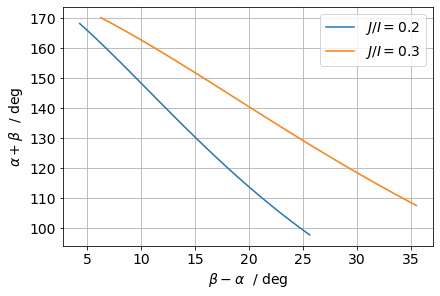

In [2]:
JI = [0.2, 0.3]
alpha = np.linspace(36, 82, 50) * degree

plt.close("all")

for j in JI:
    beta, c = [], None
    for a in alpha:
        c = FallingCat(j, a, init=c)
        beta.append(c.beta)

    ba = (beta - alpha) / degree
    ab = (alpha + beta) / degree
    plt.plot(ba, ab, label="$J/I=%g$" % j)

plt.legend()
plt.xlabel(r"$\beta - \alpha$  / deg")
plt.ylabel(r"$\alpha + \beta$  / deg")
plt.grid()
# plt.tight_layout()
plt.show()

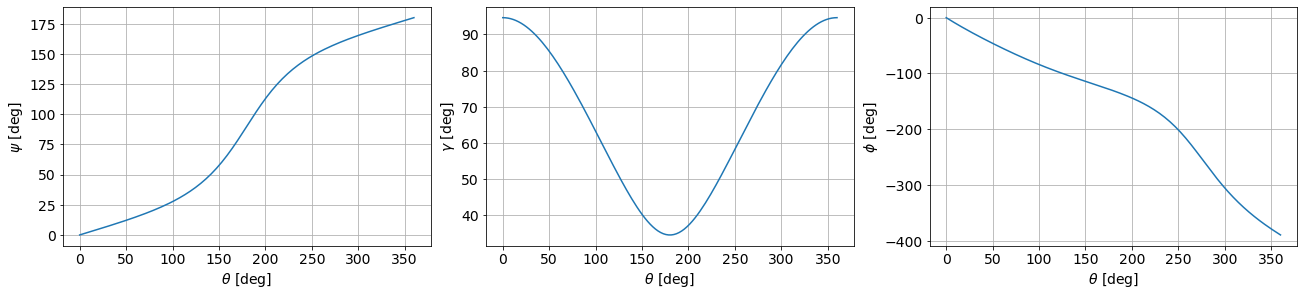

In [3]:
JI = 0.25
alpha = 30 * degree

c = FallingCat(JI, alpha)

t = c.theta / degree
psi = c.lean() / degree
gamma = c.bend() / degree
phi = c.twist() / degree

# print(phi[-1])
# print((c.alpha + c.beta) / degree)
# print((c.beta - c.alpha) / degree)

plt.close("all")

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].plot(t, psi)
ax[0].set_xlabel(r"$\theta$ [deg]")
ax[0].set_ylabel(r"$\psi$ [deg]")
ax[0].grid()

ax[1].plot(t, gamma)
ax[1].set_xlabel(r"$\theta$ [deg]")
ax[1].set_ylabel(r"$\gamma$ [deg]")
ax[1].grid()

ax[2].plot(t, phi)
ax[2].set_xlabel(r"$\theta$ [deg]")
ax[2].set_ylabel(r"$\phi$ [deg]")
ax[2].grid()

# plt.tight_layout()
plt.show()

interactive(children=(FloatSlider(value=0.0, description='theta', max=6.283185307179586), Output()), _dom_clas…

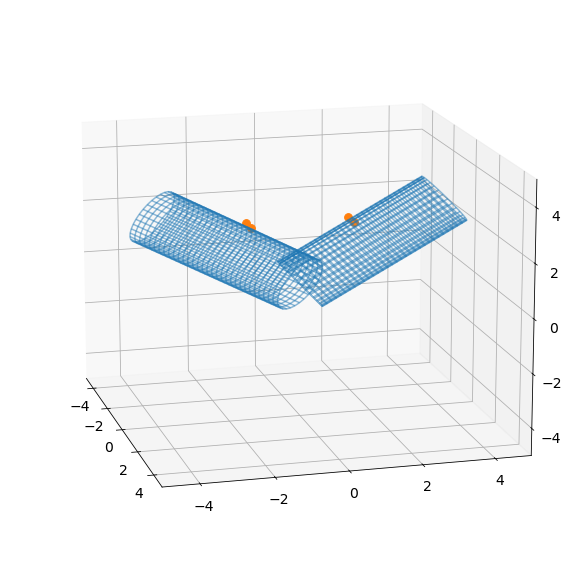

In [19]:
JI = 0.25
alpha = 10 * degree
c = FallingCat(JI, alpha)

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": "3d"})
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax.autoscale(False)
ax.axis("equal")
ax.view_init(15, -15)


def plot_cat_position(theta=0):
    ax.cla()
    c.plot(theta, ax=ax, l=5, N=32, color="C0", leg_color="C1", marker="o", s=60)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-5, 5)


interact(plot_cat_position, theta=(0, 2 * np.pi));